# Query Domain Classification
Build a system to categorize the query on the basis of the domain using Natural Language Processing.

**Problem Statement**

DSForum is a community-based portal where users can post queries related to data science topics such as machine learning, statistical analysis, data visualization, etc. The company optimizes the response time of the query by answering the query to the earliest. Nevertheless, the community can answer the queries through discussion forums. The queries might be related to different domains like Techniques, Tools, Careers, etc. 

Currently, the users manually tag the queries while posting the query into any of these categories: Techniques, Tools, Career, Hackathons, Resources, Misc, or Other. The query is then forwarded to the concerned team. This process is more error-prone and impacts the query response time. 

Can we design and develop a model that can accurately classify queries based on their domain? This will help the team to improve the response time of the platform by accurately identifying the domain of a query and redirecting it to the appropriate team and resolving the queries to the earliest. 

**Data Dictionary**

You are provided with 3 files - train.csv, test.csv, and sample_submission.csv

*Train and Test Set*

The train and test set contains the queries from different timespans. The train set includes the target variable ‘domain’ whereas in the test set, you need to predict the target variable ‘domain’. The target variable category contains multiple classes like Techniques, Tools, Career, Hackathons, Resources, Misc, Other.

| Variable | Description                           |
|----------|---------------------------------------|
| ID       | Unique identifier of the query        |
| Title    | Title of the query                    |
| Domain   | Domain of the query (Target Variable) |


*Submission File Format*

The solution file should follow a format similar to that of the sample submission file. sample_submission.csv contains 2 variables - ID and Domain.

| Variable | Description                    |
|----------|--------------------------------|
| ID       | Unique identifier of the query |
| Domain   | Domain of the query            |

**Evaluation metric**

The evaluation metric for this hackathon would be Macro F1 Score.

**Public and Private Split**

Test data is further divided into Public (40%) and Private (60%) data. Your initial responses will be checked and scored on the Public data. The final rankings would be based on your private score which will be published once the competition is over.

**Guidelines for Final Submission**

Please ensure that your final submission includes the following:
1. Solution file containing the predictions for the ID in the test set (Format is given in sample_submission.csv)
2. A zipped file containing code & approach
    * Code: Clean code with comments on each part
    * Approach: Please share your approach to solve the problem (doc/ppt/pdf format). It should cover the following topics:
        * A brief on the approach used to solve the problem. 
        * Which Data-preprocessing / Feature Engineering ideas really worked? 
        * How does your final model look like? How did you reach it?


**Rules and Conditions**

1. The final standings would be based on the private leaderboard score.
2. Setting the final submission is recommended. Without a final submission, the submission corresponding to the best public score will be taken as the final submission
3. Use of external data is not allowed.
4. The submitted code file must be able to reproduce a similar score to that of the final submission file.
5. The code file pertaining to your final submission is mandatory while setting final submission.
6. Entries submitted after the contest is closed, will not be considered
7. Throughout the hackathon, you are expected to respect fellow hackers and act with high integrity.
8. Use of multiple Login IDs will lead to immediate disqualification
9. Analytics Vidhya holds the right to disqualify any participant at any stage of the competition if the participant(s) are deemed to be acting fraudulently.

### Load the Workspace

In [141]:
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from spacy.tokens import Doc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import normalize
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, f1_score, make_scorer
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline

### Load the data

In [142]:
train = pd.read_csv('train_3.csv')
test = pd.read_csv('test_ZUT1mqB.csv')
sample = pd.read_csv('sample_submission_1_mh4j3tR.csv')

In [143]:
train.head()

,ID,Title,Domain
0,1,"What is good in a decision tree, a large or a ...",Techniques
1,2,Training data only contains single positive label,Techniques
2,3,Calculating percentage contribution of a negat...,Techniques
3,4,Unable to open solution checker!,Hackathons
4,5,User Name Change,Misc


### Data Exploration

In [144]:
train.iloc[0]

ID                                                        1
Title     What is good in a decision tree, a large or a ...
Domain                                           Techniques
Name: 0, dtype: object

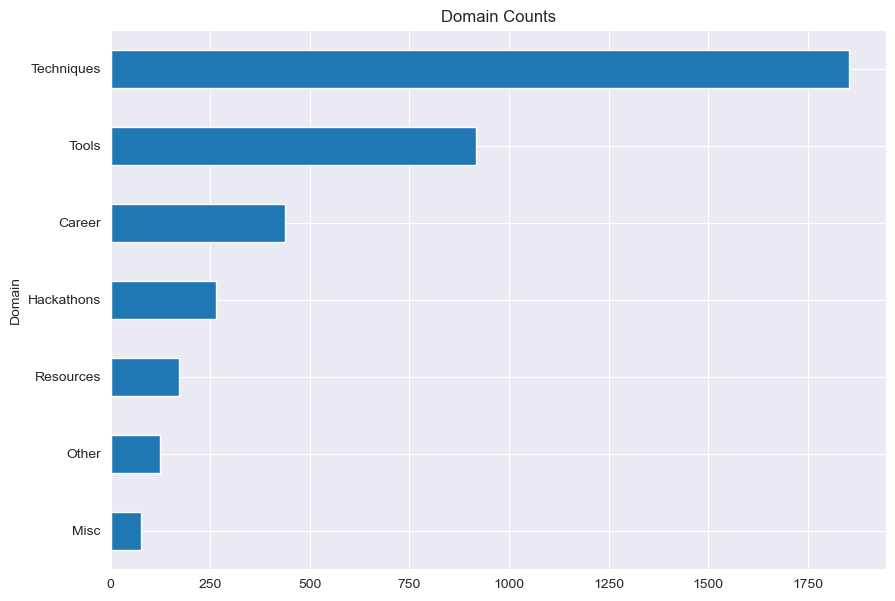

In [145]:
train.Domain.value_counts(dropna=False).plot(kind='barh',stacked=True,figsize=(10,7), title='Domain Counts')
plt.gca().invert_yaxis()

In [146]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3845 entries, 0 to 3844
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3845 non-null   int64 
 1   Title   3834 non-null   object
 2   Domain  3845 non-null   object
dtypes: int64(1), object(2)
memory usage: 90.2+ KB


In [147]:
train.loc[train.Title.isna()]

,ID,Title,Domain
438,439,NaN,Resources
771,772,NaN,Misc
794,795,NaN,Hackathons
927,928,NaN,Misc
1265,1266,NaN,Other
1425,1426,NaN,Resources
2199,2200,NaN,Hackathons
2364,2365,NaN,Career
2663,2664,NaN,Other
3472,3473,NaN,Other


In [148]:
train = train.drop(index=train.loc[train.Title.isna()].index)

### Feature Engineering

**Split into Training and Validation Set**

In [149]:
X_train, X_val, y_train, y_val = train_test_split(train.Title, train.Domain, test_size=.3, random_state=42)

In [150]:
print("type of X_train: {}".format(type(X_train)))
print("length of X_train: {}".format(len(X_train)))
print("X_train[6]:\n{}".format(X_train.iloc[6]))

type of X_train: <class 'pandas.core.series.Series'>
length of X_train: 2683
X_train[6]:
Data analytics /data science career after 2yrs break


In [151]:
np.unique(y_train)

array(['Career', 'Hackathons', 'Misc', 'Other', 'Resources', 'Techniques',
       'Tools'], dtype=object)

In [152]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform text classes to numerical labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Get counts of each numerical label using np.bincount()
print("Samples per class (training): {}".format(np.bincount(y_train_encoded)))

Samples per class (training): [ 295  186   53   82  115 1319  633]


**Representing the Queries as Bag of Words**

One of the most simple but effective and commonly used ways to represent text for ML is using the bag-of-words representation. When using this representation, we only count how often each word appears in each text in the corpus.


The shape of X_train_vect, the bag-of-words representation of the training data is 2683x3288, indicating that the vocabulary contains 3288 entries. The data is stored as a SciPy sparse matrix.

In [153]:
vect = CountVectorizer().fit(X_train)
X_train_vect = vect.transform(X_train)
print("X_train_vect:\n{}".format(repr(X_train_vect)))

X_train_vect:
<2683x3288 sparse matrix of type '<class 'numpy.int64'>'
	with 20182 stored elements in Compressed Sparse Row format>


We'll access the vocabulary by using the get_feature_name method of the vectorizer, which returns a convenient list where each entry corresponds to one feature:

In [154]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 210 to 230:\n{}".format(feature_names[210:230]))
print("Every 200th feature:\n{}".format(feature_names[::200]))

Number of features: 3288
First 20 features:
['000' '00000' '04' '10' '100' '1000' '10000' '101' '12' '13' '14' '140'
 '14th' '15' '1598' '16' '19' '1970' '1999' '1st']
Features 210 to 230:
['argv' 'arima' 'arithmetica' 'arma' 'armed' 'arr' 'arrange' 'array'
 'arrays' 'arrive' 'art' 'article' 'artificial' 'as' 'ascertaining'
 'ascii' 'ask' 'asking' 'asks' 'aspects']
Every 200th feature:
['000' 'april' 'breadth' 'competition' 'defining' 'energy' 'forums' 'hsd'
 'july' 'matchbox' 'note' 'politics' 'realiably' 'screening' 'stats'
 'transferring' 'week']


We have the training labels stored in y_train and the bag-of-words representation of the training data in X_train_vect. For high-dimensional, sparse data like this, linear models like LogisticRegression often work best.

Let’s start by evaluating Logistic Regression using cross-validation:

In [155]:
scores = cross_val_score(LogisticRegression(), X_train_vect, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.67


We obtain a mean cross-validation score of 67%, which indicates fair performance for a balanced binary classification task. We know that LogisticRegression has a regularization parameter, C, which we can tune via cross-validation:

In [156]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train_vect, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.67
Best parameters:  {'C': 1}


In [157]:
X_val_vect = vect.transform(X_val)
print("Test score: {:.2f}".format(grid.score(X_val_vect, y_val)))

Test score: 0.66


**Improving Word Extraction**

We'll reduce the token extraction to token that apprear in a minimum of 5 queries:

In [158]:
vect = CountVectorizer(min_df=5).fit(X_train)
X_train_vect = vect.transform(X_train)
print("X_train with min_df: {}".format(repr(X_train_vect)))

X_train with min_df: <2683x669 sparse matrix of type '<class 'numpy.int64'>'
	with 16028 stored elements in Compressed Sparse Row format>


In [159]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 210 to 230:\n{}".format(feature_names[210:230]))
print("Every 100th feature:\n{}".format(feature_names[::100]))

Number of features: 669
First 20 features:
['10' '12' '15' '2015' '2018' 'able' 'about' 'access' 'accuracy' 'actual'
 'add' 'advice' 'after' 'ai' 'aic' 'algorithm' 'algorithms' 'all' 'am'
 'an']
Features 210 to 230:
['freshers' 'friday' 'from' 'function' 'functions' 'gbm' 'generate' 'get'
 'getting' 'ggplot' 'ggplot2' 'given' 'go' 'good' 'google' 'got'
 'gradient' 'graph' 'great' 'grid']
Every 100th feature:
['10' 'codes' 'fold' 'language' 'option' 'same' 'training']


There are clearly many fewer numbers, and some of the more obscure words or misspellings seem to have vanished. When we test this new model, we find that accuracy has dropped slighlty. The Model, though not improved, performs faster with fewer features.

In [160]:
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train_vect, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.66


**Stop-words**

This discards words that are too frequent to be informative. There are 2 main approaches:
* using a language-specific list of stopwords
* dsicarding words that appear too frequently.

In [161]:
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['seems', 'bottom', 'indeed', 'next', 'these', 'everyone', 'my', 'whoever', 'into', 'is', 'which', 'someone', 'seemed', 'am', 'none', 'been', 'yourselves', 'much', 'fill', 'thereupon', 'because', 'since', 'whether', 'somewhere', 'couldnt', 'without', 'yourself', 'whence', 'are', 'there', 'thence', 'therein']


Removing the stopwords in the list can only decrease the number of features by the length of the list—here, 318—but it might lead to an improvement in performance.

When using english stopwords, performance reduced slightly, while frequently occurring words keeps accuracy around the same mark.

In [162]:
vect = CountVectorizer(min_df=5, stop_words="english").fit(X_train)
X_train_vect = vect.transform(X_train)
print("X_train with min_df: {}".format(repr(X_train_vect)))

X_train with min_df: <2683x573 sparse matrix of type '<class 'numpy.int64'>'
	with 9259 stored elements in Compressed Sparse Row format>


In [163]:
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train_vect, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.65


In [164]:
vect = CountVectorizer(min_df=5, max_df=1000).fit(X_train)
X_train_vect = vect.transform(X_train)
print("X_train with min_df: {}".format(repr(X_train_vect)))

X_train with min_df: <2683x669 sparse matrix of type '<class 'numpy.int64'>'
	with 16028 stored elements in Compressed Sparse Row format>


In [165]:
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train_vect, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.66


**Rescaling the Data with tf-idf**

Instead of dropping features that are deemed unimportant, another approach is to rescale features by how informative we expect them to be. One of the most common ways to do this is using the term frequency–inverse document frequency (tf–idf) method. If a word appears often in a particular document, but not in very many documents, it is likely to be very descriptive of the content of that document.

However, our model is still not improved:

In [166]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(max_iter=1000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.65


Let's inspect which words tf–idf found most important:

In [167]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]

# transform the training dataset:
X_train_vect = vectorizer.transform(X_train)

# find maximum value for each of the features over dataset:
max_value = X_train_vect.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['how' 'regression' 'machine' 'use' 'which' 'between' 'help' 'while' 'be'
 'classification' 'prediction' 'we' 'does' 'why' 'difference' 'when'
 'find' 'need' 'big' 'algorithm']
Features with highest tfidf: 
['sql' 'year' 'study' 'time' 'row' 'encoding' 'estimate' 'survival'
 'shape' 'cv' 'test' 'loop' 'objects' 'implementing' 'standard' 'squared'
 'business' 'nlp' 'h2o' 'bar']


Features with low tf–idf are those that either are very commonly used across documents or are only used sparingly, and only in very long documents.

We can also find the words that have low inverse document frequency—that is, those that appear frequently and are therefore deemed less important. The inverse document frequency values found on the training set are stored in the idf_ attribute:

In [168]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
    feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['in' 'to' 'how' 'data' 'for' 'the' 'of' 'and' 'is' 'using' 'python'
 'analytics' 'what' 'with' 'from' 'on' 'learning' 'model' 'error' 'can'
 'science' 'regression' 'analysis' 'variable' 'machine' 'time' 'use'
 'which' 'between' 'problem' 'are' 'help' 'dataset' 'or' 'sas' 'not'
 'test' 'values' 'do' 'value' 'while' 'be' 'series' 'career'
 'classification' 'file' 'function' 'text' 'business' 'prediction'
 'variables' 'we' 'does' 'plot' 'why' 'difference' 'missing' 'when' 'best'
 'need' 'find' 'it' 'big' 'into' 'algorithm' 'random' 'vs' 'code'
 'multiple' 'an' 'one' 'categorical' 'get' 'set' 'by' 'logistic' 'should'
 'feature' 'create' 'course' 'forest' 'package' 'as' 'column' 'decision'
 'number' 'training' 'different' 'used' 'linear' 'models' 'qlikview'
 'large' 'tree' 'calculate' 'learn' 'predict' 'accuracy' 'excel' 'two']


**Bag of words with more than one word (n-grams)**

There is a way of capturing context when using a bag-of-words representation, by not only considering the counts of single tokens, but also the counts of pairs or triplets of tokens that appear next to each other. Pairs of tokens are known as bigrams, triplets of tokens are known as trigrams, and more generally sequences of tokens are known as n-grams.

In [169]:
pipe = make_pipeline(
    TfidfVectorizer(min_df=5), LogisticRegression(max_iter=1000)
)

# running the grid-search takes a long time because of the relatively large grid and the inclusion of trigrams
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100], "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]
}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.65
Best parameters:
{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 1)}


From the heatmap we can see that using bigrams and trigrams reduce performance.

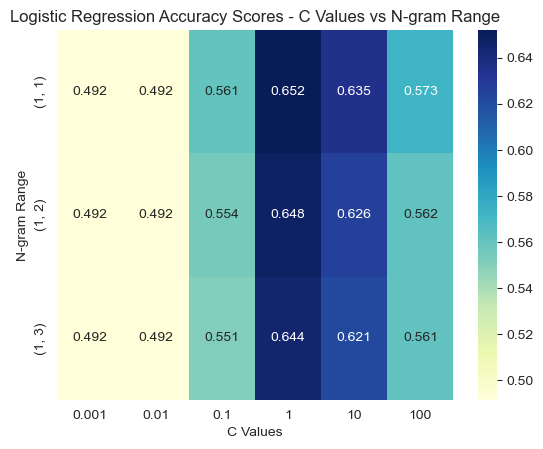

In [170]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T

# visualize heat map
sns.heatmap(
    scores, cmap="YlGnBu", annot=True, fmt=".3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range']
)
plt.ylabel('N-gram Range')
plt.xlabel('C Values')
plt.title('Logistic Regression Accuracy Scores - C Values vs N-gram Range')
plt.show()

In [171]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names_out())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_

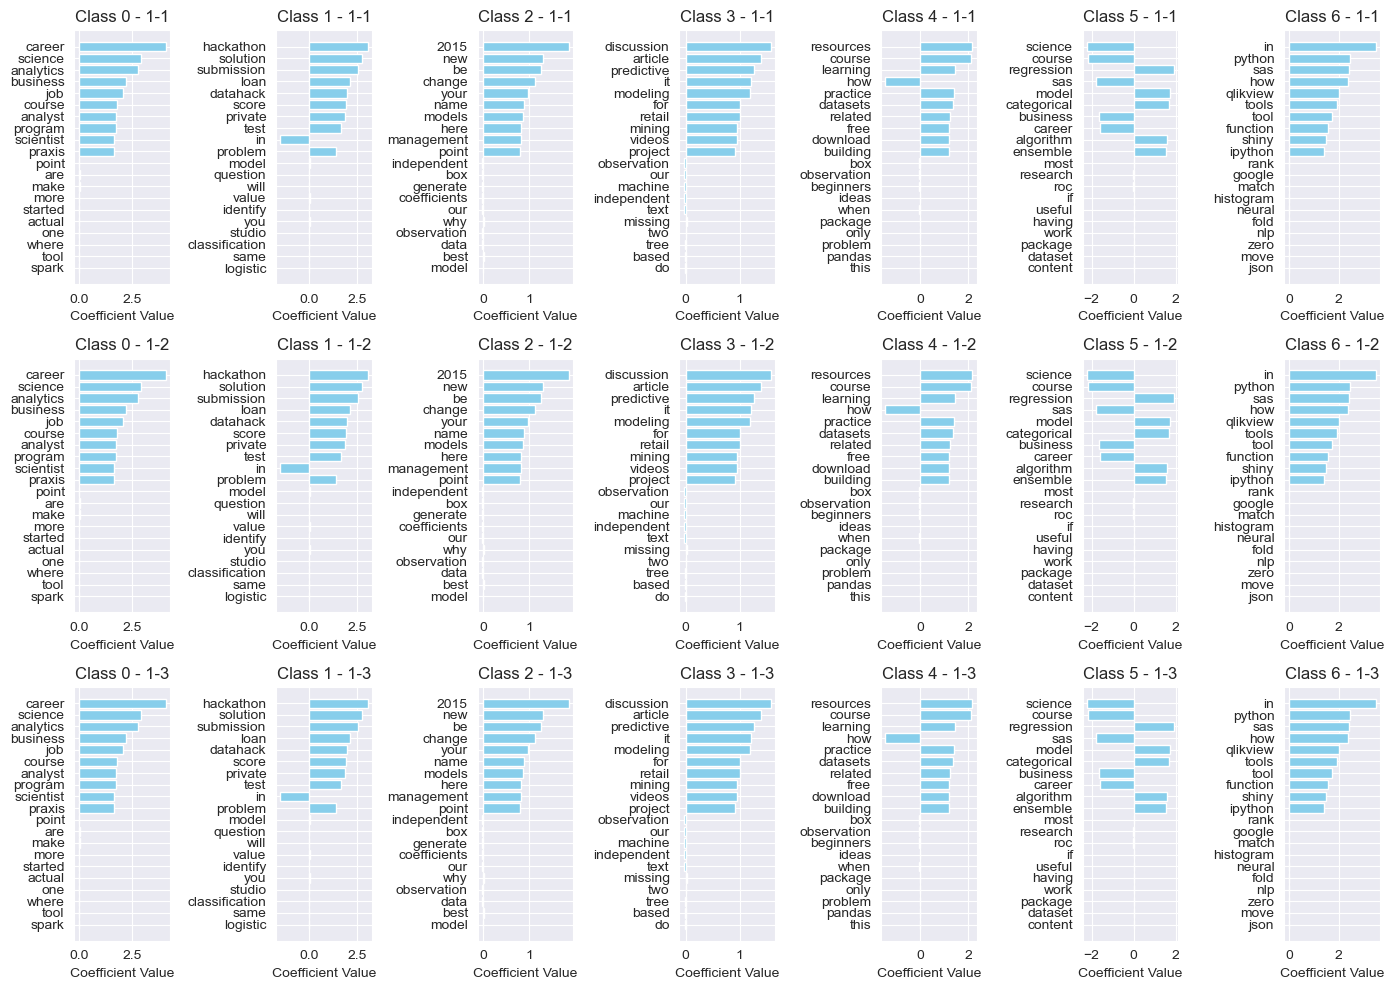

In [172]:
# Define n-gram ranges
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # Unigrams, bigrams, and trigrams

# Plot coefficients for each class separately
plt.figure(figsize=(14, 10))
for i, ngram_range in enumerate(ngram_ranges):
    for class_index in range(coef.shape[0]):
        rel_coef = coef[class_index]
        # Sort coefficients indices based on absolute value to get top features
        sorted_indices = np.argsort(np.abs(rel_coef))
        top_indices = np.concatenate((sorted_indices[:10], sorted_indices[-10:]))
    
        # Plot important coefficients for each class and n-gram range
        plt.subplot(len(ngram_ranges), coef.shape[0], i * coef.shape[0] + class_index + 1)
        plt.barh(range(len(top_indices)), rel_coef[top_indices], color='skyblue')
        plt.yticks(range(len(top_indices)), feature_names[top_indices])
        plt.title(f'Class {class_index} - {ngram_range[0]}-{ngram_range[1]}')
        plt.xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

**Advanced tokenization, stemming and lemmatization**

Tokenization is the process of breaking down text into smaller units called tokens. These tokens can be words, phrases, sentences, or even characters, depending on the granularity required for analysis. It defines what constitutes a word for the purpose of feature extraction.

Stemming is the process of reducing words to their root or base form (stem) by removing suffixes. It aims to reduce words to a common base form, even if the stem itself is not a valid word.

Lemmatization is similar to stemming but aims to obtain the base or dictionary form of a word (known as the lemma) by considering the word's context and meaning. Unlike stemming, lemmatization ensures that the root word obtained is a valid word present in the language.

Both processing methods, lemmatization and stemming, are forms of normalization that try to extract some normal form of a word. Another interesting case of normalization is spelling correction.

In [173]:
# regexp used in CountVectorizer:
regexp = re.compile('(?u)\\b\\w\\w+\\b')
# load spacy language model
en_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# replace the tokenizer with the preceding regexp
en_nlp.tokenizer = lambda string: Doc(en_nlp.vocab, words=regexp.findall(string))

# create a custom tokenizer using the SpaCy document processing pipeline (now using our own tokenizer)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

In [174]:
# transform text_train using CountVectorizer with lemmatization
X_train_lemma = lemma_vect.fit_transform(X_train)
print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

# standard CountVectorizer for reference
vect = CountVectorizer(min_df=5).fit(X_train)
X_train_vect = vect.transform(X_train)
print("X_train_vect.shape: {}".format(X_train_vect.shape))

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train_lemma.shape: (2683, 637)
X_train_vect.shape: (2683, 669)


Lemmatization reduced the number of features by 30. Lemmatization can be seen as a kind of regularization, as it conflates certain features. Therefore, we expect lemmatization to improve performance most when the dataset is small.

In [175]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
# We'll use StratifiedShuffleSplit for cross-validation, using only 1% of the data as training data and the rest as test data:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99, train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=cv)
# perform grid search with standard CountVectorizer
grid.fit(X_train_vect, y_train)
print("Best cross-validation score "
      "(standard CountVectorizer): {:.3f}".format(grid.best_score_))

# perform grid search with Lemmatization
grid.fit(X_train_lemma, y_train)
print("Best cross-validation score "
      "(lemmatization): {:.3f}".format(grid.best_score_))

Best cross-validation score (standard CountVectorizer): 0.501
Best cross-validation score (lemmatization): 0.498


**Tuning logistic regression hyperparameters with grid search**

In [176]:
# Represent the review text as a bag-of-words
vect = CountVectorizer()
X_train_vect = vect.fit_transform(X_train)
X_val_vect = vect.transform(X_val)
len(vect.vocabulary_)

3288

In [177]:
# Create the tf-idf representation using the bag-of-words matrix
tfidf_trfm = TfidfTransformer(norm=None) 
X_tr_tfidf = tfidf_trfm.fit_transform(X_train_vect) 
X_val_tfidf = tfidf_trfm.transform(X_val_vect)

# l2-normalize the bag-of-words representation 
X_tr_l2 = normalize(X_train_vect, axis=0)
X_val_l2 = normalize(X_val_vect, axis=0)

The results show that the most accurate classifier is the one using BoW features.

In [178]:
def simple_logistic_classify(
        X_train, y_train, X_test, y_test, description, _C=1.0
):
    ## Helper function to train a logistic classifier and score on test data
    m = LogisticRegression(C=_C, max_iter=1000).fit(X_train, y_train)
    s = m.score(X_test, y_test)
    print ('Test score with', description, 'features:', s)
    return m

m1 = simple_logistic_classify(X_train_vect, y_train, X_val_vect, y_val, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_train, X_val_l2, y_val, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_train, X_val_tfidf, y_val, 'tf-idf')

Test score with bow features: 0.6646394439617723
Test score with l2-normalized features: 0.6194613379669852
Test score with tf-idf features: 0.635968722849696


In [179]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}

In [180]:
# Tune classifier for bag-of-words representation
bow_search = GridSearchCV(
    LogisticRegression(max_iter=1000), cv=5, param_grid=param_grid_
)
bow_search.fit(X_train_vect, y_train)
bow_search.cv_results_

{'mean_fit_time': array([0.33945861, 0.10712957, 0.1499866 , 0.3006309 , 0.42508821,
        0.69171743]),
 'std_fit_time': array([0.06820694, 0.05466281, 0.046205  , 0.07316649, 0.06332227,
        0.07935968]),
 'mean_score_time': array([0.00089383, 0.00072021, 0.00088902, 0.00081339, 0.00066953,
        0.00088181]),
 'std_score_time': array([2.20645543e-04, 4.46212075e-05, 1.60858554e-04, 1.71304079e-04,
        5.46606818e-05, 2.14770579e-04]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_score': array([0.49162011, 0.49162011, 0.6443203 , 0.66294227, 0.64804469,
        0.63314711]),
 'split1_test_score': array([0.49162011, 0.49162011, 0.62569832, 0.67970205, 0.66108007,
        0.64804469]),
 'split2_test_score': array([0.4916201

In [181]:
# Tune classifier for L2-normalized word vector
l2_search = GridSearchCV(
    LogisticRegression(max_iter=1000), cv=5, param_grid=param_grid_
)
l2_search.fit(X_tr_l2, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [182]:
# Tune classifier for tf-idf
tfidf_search = GridSearchCV(
    LogisticRegression(max_iter=1000), cv=5, param_grid=param_grid_
)
tfidf_search.fit(X_tr_tfidf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [183]:
search_results = pd.DataFrame.from_dict({
    'bow': bow_search.cv_results_['mean_test_score'],
    'tfidf': tfidf_search.cv_results_['mean_test_score'],
    'l2': l2_search.cv_results_['mean_test_score']
})

search_results

,bow,tfidf,l2
0,0.491614,0.491614,0.491614
1,0.491614,0.584050,0.491614
2,0.635861,0.661210,0.491614
3,0.670151,0.643325,0.558709
4,0.656366,0.628035,0.638100
5,0.639962,0.619833,0.632878


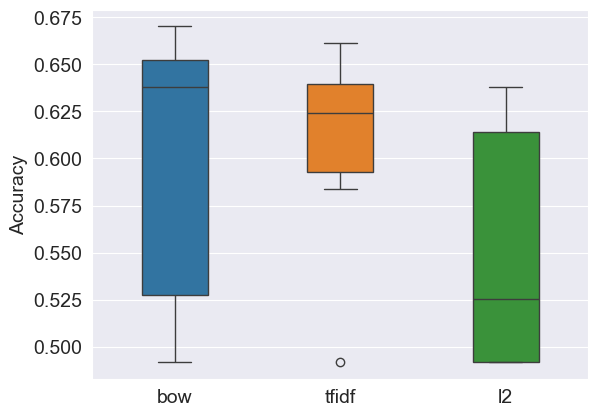

In [184]:
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)

Final training and testing step to compare the different feature sets:

In [185]:
# Train a final model on the entire training set, using the best hyperparameter # settings found previously. Measure accuracy on the test set.
m1 = simple_logistic_classify(X_train_vect, y_train, X_val_vect, 
                              y_val, 'bow',
                              _C=bow_search.best_params_['C'])
m2 = simple_logistic_classify(X_tr_l2, y_train, X_val_l2, y_val, 
                              'l2-normalized', 
                              _C=l2_search.best_params_['C'])
m3 = simple_logistic_classify(X_tr_tfidf, y_train, X_val_tfidf, y_val, 
                              'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test score with bow features: 0.6646394439617723
Test score with l2-normalized features: 0.6411815812337098
Test score with tf-idf features: 0.6585577758470895


Multiclass Classification - Other Models

In [186]:
X_train, X_val, y_train, y_val = train_test_split(train.Title, train.Domain, test_size=.3, random_state=42)

Bag-of-Words

In [187]:
vect = CountVectorizer().fit(X_train)
X_train_vect = vect.transform(X_train)
X_val_vect = vect.transform(X_val)

BoW—Stopwords

In [188]:
stop_vect = CountVectorizer(min_df=5, stop_words="english").fit(X_train)
X_train_stopvect = stop_vect.transform(X_train)
X_val_stopvect = stop_vect.transform(X_val)

TfidTransformer

In [189]:
tfidf_trfm = TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_train_vect)
X_val_tfidf = tfidf_trfm.transform(X_val_vect)

l2-normalize bag-of-words representation 

In [190]:
X_train_l2 = normalize(X_train_vect, axis=0)
X_val_l2 = normalize(X_val_vect, axis=0)

TfidVectorizer

In [191]:
tfidf_vect = TfidfVectorizer(norm=None)
X_train_tfidfvect = tfidf_vect.fit_transform(X_train)
X_val_tfidfvect = tfidf_vect.transform(X_val)

lemmatization

In [192]:
regexp = re.compile('(?u)\\b\\w\\w+\\b')
en_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
en_nlp.tokenizer = lambda string: Doc(en_nlp.vocab, words=regexp.findall(string))

def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)
X_train_lemma = lemma_vect.fit_transform(X_train)
X_val_lemma = lemma_vect.transform(X_val)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Stemming

In [193]:
# Initialize Porter Stemmer
stemmer = PorterStemmer()

# Custom tokenizer function with stemming
def custom_tokenizer_stemming(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Apply stemming to each word token using Porter Stemmer
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    return stemmed_tokens

stem_vect = TfidfVectorizer(tokenizer=custom_tokenizer_stemming)
X_train_stem = stem_vect.fit_transform(X_train)
X_val_stem = stem_vect.transform(X_val)

Models:

In [194]:
def simple_classifier(
        model, X_train, y_train, X_test, y_test, description, 
):
    ## Helper function to train a classifier and score on test data
    m = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    s = f1_score(y_test, y_pred, average='macro')
    print ('Test F1 Macro score with', description, 'features:', format(s, '.3f'))
    return m

In [195]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary of class weights
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Calculate class priors from class weights
class_priors = class_weights / len(y_train)

# Create a dictionary of class priors
class_prior_dict = dict(zip(np.unique(y_train), class_priors))

In [196]:
lr = LogisticRegression(max_iter=1000, class_weight=class_weight_dict)
sgd_clf = SGDClassifier(max_iter=1000, class_weight=class_weight_dict)
linear_svc = LinearSVC(max_iter=1000, class_weight=class_weight_dict)
svc = SVC(max_iter=1000, class_weight=class_weight_dict)
tree_clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, class_weight='balanced')
rf_clf = RandomForestClassifier(max_depth=4, min_samples_leaf=5, class_weight='balanced')
et_clf = ExtraTreesClassifier(max_depth=4, min_samples_leaf=5, class_weight='balanced')
gb_clf = GradientBoostingClassifier(max_depth=4, min_samples_leaf=5)
knn_clf = KNeighborsClassifier(n_neighbors=3)
nb_clf = MultinomialNB()
xgb = XGBClassifier()

Predictions and Scores:

In [197]:
feature_descriptions = ['BoW', 'BoW-Stopwords', 'TfidTransformer', 'l2_BoW', 'TfidVectorizer', 'Lemmatization', 'Stemming']

model_names = ['LogisticRegression', 'SGDClassifier', 'LinearSVC', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'NaiveBayesClassifier']

train_sets = [X_train_vect, X_train_stopvect, X_tr_tfidf, X_train_l2, X_train_tfidfvect, X_train_lemma, X_train_stem]

val_sets = [X_val_vect, X_val_stopvect, X_val_tfidf, X_val_l2, X_val_tfidfvect, X_val_lemma, X_val_stem]

models = [lr, sgd_clf, linear_svc, svc, tree_clf, rf_clf, et_clf, gb_clf, knn_clf, nb_clf]

In [198]:
for model, model_name in zip(models, model_names):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(model_name)
        
        try:
            for train, val, feature_description in zip(train_sets, val_sets, feature_descriptions):
                simple_classifier(
                    model, train, y_train, val, y_val, feature_description,
                )
        except TypeError as e:
            print(e)
        print('\n')

LogisticRegression
Test F1 Macro score with BoW features: 0.433
Test F1 Macro score with BoW-Stopwords features: 0.395
Test F1 Macro score with TfidTransformer features: 0.416
Test F1 Macro score with l2_BoW features: 0.463
Test F1 Macro score with TfidVectorizer features: 0.416
Test F1 Macro score with Lemmatization features: 0.416
Test F1 Macro score with Stemming features: 0.462


SGDClassifier
Test F1 Macro score with BoW features: 0.397
Test F1 Macro score with BoW-Stopwords features: 0.365
Test F1 Macro score with TfidTransformer features: 0.413
Test F1 Macro score with l2_BoW features: 0.428
Test F1 Macro score with TfidVectorizer features: 0.425
Test F1 Macro score with Lemmatization features: 0.396
Test F1 Macro score with Stemming features: 0.444


LinearSVC
Test F1 Macro score with BoW features: 0.411
Test F1 Macro score with BoW-Stopwords features: 0.379
Test F1 Macro score with TfidTransformer features: 0.364
Test F1 Macro score with l2_BoW features: 0.442
Test F1 Macro sc

In [199]:
for train, val, feature_description in zip(train_sets, val_sets, feature_descriptions):
    simple_classifier(
        xgb, train, y_train_encoded, val, y_val_encoded, feature_description,
    )

Test F1 Macro score with BoW features: 0.398
Test F1 Macro score with BoW-Stopwords features: 0.401
Test F1 Macro score with TfidTransformer features: 0.398
Test F1 Macro score with l2_BoW features: 0.401
Test F1 Macro score with TfidVectorizer features: 0.398
Test F1 Macro score with Lemmatization features: 0.426
Test F1 Macro score with Stemming features: 0.411


The best models are Logistic Regression, SGDCLassifier, Linear SVC and Naive Bayes. The best features are stemmed and l2 normalizaed. We'll combine both and retry with the models. 

In [200]:
stemmer = PorterStemmer()

def custom_tokenizer_stemming(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

stem_vect = TfidfVectorizer(tokenizer=custom_tokenizer_stemming)
X_train_stem = stem_vect.fit_transform(X_train)
X_val_stem = stem_vect.transform(X_val)

X_train_stem_l2 = normalize(X_train_stem, axis=0)
X_val_stem_l2 = normalize(X_val_stem, axis=0)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [201]:
model_names = ['LogisticRegression', 'SGDClassifier', 'LinearSVC']
models = [lr, sgd_clf, linear_svc]

for model, model_name in zip(models, model_names):
    print(model_name)
    simple_classifier(
        model, X_train_stem_l2, y_train, X_val_stem_l2, y_val, 'L2-Stem'
    )
    print('\n')

LogisticRegression
Test F1 Macro score with L2-Stem features: 0.460


SGDClassifier
Test F1 Macro score with L2-Stem features: 0.433


LinearSVC
Test F1 Macro score with L2-Stem features: 0.449



/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Best model is logistic regression and linearsvc with l2-normalized bag of words and stemming features.

We'll move to hyper parameter tuning:

In [202]:
def custom_tokenizer_stemming(text):
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

f1_macro_scorer = make_scorer(f1_score, average='macro')

Logistic Regression:

In [203]:
text_clf_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

param_grid_lr = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__tokenizer': [custom_tokenizer_stemming],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__max_iter': [1000, 2000],
    'clf__class_weight': [class_weight_dict]
}

grid_search_lr = GridSearchCV(
    text_clf_lr, param_grid_lr, cv=5, scoring=f1_macro_scorer
)
grid_search_lr.fit(X_train, y_train)

best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

print("Best Parameters for Logistic Regression:", best_params_lr)
print("Best F1 Macro Score for Logistic Regression:", best_score_lr)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/t

Best Parameters for Logistic Regression: {'clf__C': 10.0, 'clf__class_weight': {'Career': 1.2992736077481841, 'Hackathons': 2.0606758832565286, 'Misc': 7.231805929919138, 'Other': 4.674216027874564, 'Resources': 3.332919254658385, 'Techniques': 0.29058810787393047, 'Tools': 0.6055066576393591}, 'clf__max_iter': 2000, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'tfidf__ngram_range': (1, 2), 'tfidf__tokenizer': <function custom_tokenizer_stemming at 0x293f16e60>}
Best F1 Macro Score for Logistic Regression: 0.46986479038389184


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [204]:
text_clf_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

param_grid_svc = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__tokenizer': [custom_tokenizer_stemming],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__penalty': ['l2'],
    'clf__loss': ['hinge', 'squared_hinge'],
    'clf__max_iter': [1000, 2000],
    'clf__class_weight': [class_weight_dict]
}

grid_search_svc = GridSearchCV(
    text_clf_svc, param_grid_svc, cv=5, scoring=f1_macro_scorer
)
grid_search_svc.fit(X_train, y_train)

best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_

print("Best Parameters for LinearSVC:", best_params_svc)
print("Best F1 Macro Score for LinearSVC:", best_score_svc)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/Ca

Best Parameters for LinearSVC: {'clf__C': 1.0, 'clf__class_weight': {'Career': 1.2992736077481841, 'Hackathons': 2.0606758832565286, 'Misc': 7.231805929919138, 'Other': 4.674216027874564, 'Resources': 3.332919254658385, 'Techniques': 0.29058810787393047, 'Tools': 0.6055066576393591}, 'clf__loss': 'hinge', 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'tfidf__ngram_range': (1, 2), 'tfidf__tokenizer': <function custom_tokenizer_stemming at 0x293f16e60>}
Best F1 Macro Score for LinearSVC: 0.46975410558073794


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
